/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.


Cazuri 15/05 minim: 15700.0
Cazuri 15/05 maxim: 19991.0

Daca suntem pe linia rosie:
5000  de cazuri pe data de: 10/04
10000 de cazuri pe data de: 27/04
25000 de cazuri pe data de: 20/05
53060 de cazuri pe data de: 08/06

Daca suntem pe linia verde
Numarul maxim de cazuri va fi 16861.0
Punctul de inflexiune va fi pe 18/04


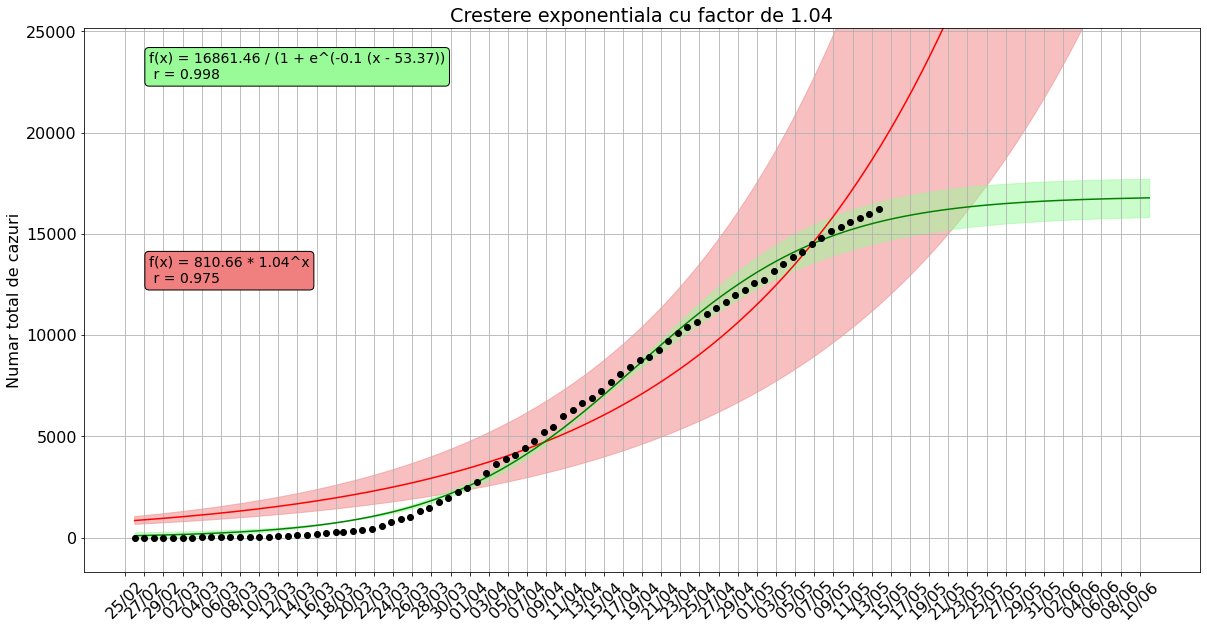

In [ ]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
 
def exp_fun(x, a, b):
    return a * b**x
 
def log_fun(x, a, b, c, d):
    return a / (1 + np.exp(-b * (x - c))) + d
 
def inv_exp(target, a, b):
    target = target / a
    return np.log(target) / np.log(b)
 
def corect_time(x, index, time_diff):
    hours     = 24  # ore intr-o zi
    x[index:]     = [time_diff / hours + x[ind - 1] for ind in np.array(range(len(x)-index)) + index]
    return x
 
def active_cases(y, time_to_recover):
    recovered_cases = 0
    for i in range(len(y)):
      if i > time_to_recover:
        recovered_cases += y[i-time_to_recover]
        y[i]             = np.max([0, y[i] - recovered_cases])
    return y
 
# introducem date
inceput  = pd.datetime(2020, 2, 25)
y = np.array([1, 1, 3, 3, 3, 3, 4, 6, 7, 9, 13, 15, 17, 29, 47, 59, 95, 123, 143, 168, 217, 260, 277, 308,\
              367, 433, 576, 762, 906, 1029, 1292, 1452, 1760, 1952, 2245, 2460, 2736, 3183, 3613, 3865, 4057,\
              4417, 4762, 5203, 5466, 5992, 6300, 6634, 6879, 7216, 7707, 8067, 8418, 8746, 8936, 9242, 9710,\
              10096, 10417, 10635, 11036, 11339, 11616, 11978, 12240, 12567, 12732, 13163, 13512, 13837, 14107,\
              14499, 14811, 15131, 15362, 15588, 15778, 16002, 16247]) # cazuri pe zile
x = np.array(range(len(y))) + 1.0                                                              # numarul zilei de la primul caz
 
# corectarea pentru ora update-ului (daca a trecut mai putin de o zi ziceti cate ore au fost intre)
x = corect_time(x, 22, 19)
x = corect_time(x, 33, 23)
 
# creearea prognozei pe baza datelor
log_bounds        = ((y[-1], 0.05, 1, 0), (19271937*0.7, 3, np.inf, np.inf))        # conditie pentru stabilitate numerica
exp_bounds        = ((0, 0.0), (np.inf, 3))                                     # conditie pentru stabilitate numerica
exp_para, exp_cov = curve_fit(exp_fun, x, y, bounds=exp_bounds, maxfev=10000)   # calculul functiei de prognoza exponentiala
log_para, log_cov = curve_fit(log_fun, x, y, bounds=log_bounds, maxfev=10000)   # calculul functiei de prognoza logistica
r_exp             = np.round(np.corrcoef(y, exp_fun(x, *exp_para))[0,1],3)      # calculul coeficientului de potrivire
r_log             = np.round(np.corrcoef(y, log_fun(x, *log_para))[0,1],3)      # calculul coeficientului de potrivire
 
# prognoza de acum 2 zile
o_log_para, _ = curve_fit(log_fun, x[:-10], y[:-10], bounds=log_bounds, maxfev=10000) # calculul functiei de prognoza logistica
#o_exp_para, _ = curve_fit(exp_fun, x[:-2], y[:-2], bounds=exp_bounds, maxfev=10000) # calculul functiei de prognoza exponentiala
 
# prognoza (a se modifica valoarea l_prog pentru a mari lungimea prognozei)
l_prog   = 28                                                              # definim lungimea in viitor a prognozei
expand_x = np.linspace(1, len(y) + l_prog, 1000)                           # definim punctele pentru prognoza
dates    = pd.date_range(start=inceput, end='01/01/2100').strftime("%d/%m")
datelist = dates[0::2] # pregatim lista de dati
ticklist = list(range(l_prog +len(y)+1))[0::2]
 
# calcularea marjelor de eroare (95%)
exp_sd = 2 * np.sqrt(np.diag(exp_cov))
log_sd = 2 * np.sqrt(np.diag(log_cov))
exp_para_max = exp_para + exp_sd
exp_para_min = exp_para - exp_sd
log_para_max = log_para + log_sd
log_para_min = log_para - log_sd
 
exp_min = exp_fun(expand_x,*exp_para_min)
exp_max = exp_fun(expand_x,*exp_para_max)
log_min = log_fun(expand_x,*log_para_min)
log_max = log_fun(expand_x,*log_para_max)
 
# pregatirea textului din in grafic
textstr_exp = 'f(x) = {} * {}^x'.format(np.round(exp_para[0],2), np.round(exp_para[1],2))+'\n r = {}'.format(r_exp)
textstr_log = 'f(x) = {} / (1 + e^(-{} (x - {}))'.format(np.round(log_para[0],2), np.round(log_para[1],2), np.round(log_para[2],2))+'\n r = {}'.format(r_log)
 
props_exp   = dict(boxstyle='round', facecolor='lightcoral') # definim cum arata cutia rosie
props_log   = dict(boxstyle='round', facecolor='palegreen')  # definim cum arata cutia verde
plt.rc('font',family='Arial', size=16)                       # definim marimea si tipul scrisului
 
# arata prognosticul de maine
diag = x[-1] + 1
print('Cazuri {} minim: {}'.format(dates[len(y)+1], np.round(log_fun(diag, *log_para))))
print('Cazuri {} maxim: {}'.format(dates[len(y)+1], np.round(exp_fun(diag, *exp_para))))
 
# arata cand se ajung la un numar de Cazuri
print('\nDaca suntem pe linia rosie:')
print('5000  de cazuri pe data de:', (inceput + datetime.timedelta(days=inv_exp(5000, *exp_para))).strftime("%d/%m"))
print('10000 de cazuri pe data de:', (inceput + datetime.timedelta(days=inv_exp(10000, *exp_para))).strftime("%d/%m"))
print('25000 de cazuri pe data de:', (inceput + datetime.timedelta(days=inv_exp(25000, *exp_para))).strftime("%d/%m"))
print('53060 de cazuri pe data de:', (inceput + datetime.timedelta(days=inv_exp(53060, *exp_para))).strftime("%d/%m"))
 
print('\nDaca suntem pe linia verde')
print('Numarul maxim de cazuri va fi {}'.format(np.round(log_para[0])))
print('Punctul de inflexiune va fi pe {}'.format(dates[np.round(log_para[2])]))
 
# plotarea punctelor si liniei
plt.figure(figsize=[20, 10])                           # initializam figura
plt.plot(expand_x, exp_fun(expand_x, *exp_para), 'r-') # adaugam prognostic exponential
plt.fill_between(expand_x, exp_min, exp_max, color='lightcoral', alpha=0.5)
plt.plot(expand_x, log_fun(expand_x, *log_para), 'g-') # adaugam prognostic logistic
plt.fill_between(expand_x, log_max, log_min, color='palegreen', alpha=0.5)
#plt.plot(expand_x, log_fun(expand_x, *o_log_para), 'g--') # adaugam prognostic logistic (doua zile in urma)
#plt.plot(expand_x, exp_fun(expand_x, *o_exp_para), 'r--') # adaugam prognostic exponential (doua zile in urma)
plt.plot(x, y, 'ko')                                   # punem punctele cu date reale
max_log = np.max(log_fun(expand_x, *log_para))
plt.ylim([-0.1 * max_log, max_log + 0.5 * max_log])
#plt.ylim([-10000,1271937])
 
# punerea textului in figura
max_y = plt.ylim()[1]
plt.text(2.5, max_y * 0.9, textstr_log, fontsize=14, bbox=props_log)  # aratam cutia verde
plt.text(2.5, max_y * 0.5, textstr_exp, fontsize=14, bbox=props_exp)  # aratam cutia rosie
plt.title('Crestere exponentiala cu factor de {}'.format(np.round(exp_para[1],decimals=2))) # titlul figurii
plt.ylabel('Numar total de cazuri')                           # numim axa y
plt.xticks(ticklist, datelist, rotation=45)     # punem data pe axa x
#plt.yscale('log')
plt.grid()
'''
days = np.array(range(len(y)+ l_prog + 1))
#plt.plot(days, active_cases(exp_fun(days, *exp_para), 13), 'r:') # adaugam prognostic exponential
plt.plot(days, active_cases(log_fun(days, *log_para), 13), 'g:') # adaugam prognostic logistic
 
for i, txt in enumerate(y):
    plt.annotate(txt, (x[i], y[i]-150), fontsize=12)
'''
 
plt.show()                                                    # aratam figura